<a href="https://colab.research.google.com/github/EdgarNH29/Ciencia-de-Datos-para-Sensores-Inteligentes/blob/main/Practica1_Edgar_Nava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ciencia de Datos para Sensores Inteligentes**

## Práctica 1: Sensado y análisis de audio
## Edgar Nava Hernández

Para la elavoracion de esta practica se recopilaron y organizaron los archivos de audio, a los cuales se les aplicó un preprocesamiento que incluyó reducción de ruido y normalización del volumen para homogeneizar las grabaciones. Posteriormente, de cada señal se extrajeron características acústicas: 13 coeficientes MFCC, la tasa de cruces por cero (ZCR) y la energía RMS, generando un vector de características por audio. Las etiquetas de clase se asignaron automáticamente a partir del nombre de los archivos.

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.listdir("/content/drive/MyDrive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Classroom',
 'Python.gdoc',
 'Mnistmain.ipynb',
 'Ejercicio SVD Semántica Latente.gdoc',
 'Tarea 1 sol.gdoc',
 'Detección de cascos',
 'aplicacion web 3d',
 'Tarea 4.gdoc',
 'Tarea1_EdgarNava.gdoc',
 'Laboratorio 1 - MQTT.gdoc',
 'RoboticaMovil',
 'IoT',
 'Tarea 4_EdgarNava.gdoc',
 'Colab Notebooks',
 'CDSI 2026',
 'Audio_limpio',
 'features_audio_train_only.csv']

In [ ]:
!pip install librosa noisereduce soundfile


Preprocesamiento automático de los archivos de audio almacenados en el conjunto de datos. Para cada grabación se aplicó una reducción de ruido de fondo y una normalización del volumen con el fin de mejorar la calidad y homogeneizar la intensidad de las señales. Los audios procesados se guardaron en una nueva carpeta, conservando la misma estructura de directorios.

In [ ]:
import os
import librosa
import numpy as np
import noisereduce as nr
import soundfile as sf

base_path = "/content/drive/MyDrive/CDSI 2026/Audio"
output_base = "Audio_limpio"

os.makedirs(output_base, exist_ok=True)

def quitar_ruido(y, sr):
    ruido = y[:int(0.5 * sr)]
    y_denoised = nr.reduce_noise(y=y, sr=sr, y_noise=ruido)
    return y_denoised


def normalizar_rms(y, target_db=-20):
    rms = np.sqrt(np.mean(y**2))
    scalar = 10**(target_db/20) / (rms + 1e-8)
    return y * scalar


contador = 0

for root, dirs, files in os.walk(base_path):

    for file in files:
        if file.endswith(".wav"):

            path_in = os.path.join(root, file)

            relative = os.path.relpath(root, base_path)
            out_dir = os.path.join(output_base, relative)
            os.makedirs(out_dir, exist_ok=True)

            path_out = os.path.join(out_dir, file)

            y, sr = librosa.load(path_in, sr=None)

            y = quitar_ruido(y, sr)
            y = normalizar_rms(y)

            sf.write(path_out, y, sr)

            contador += 1

print("Audios procesados:", contador)


Audios procesados: 198


Extracción de características acústicas (MFCC, ZCR y RMS) de cada audio y se construyó un Dataframe etiquetado automáticamente para su uso en el entrenamiento de modelos de clasificación.

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

labels_validas = ["bano", "oficina", "nula", "sala", "pasos", "cocina"]


def crear_dataframe_features(base_path, excluir=None):

    data = []

    for root, dirs, files in os.walk(base_path):

        if excluir and excluir in root:
            continue

        for file in files:
            if file.endswith(".wav"):

                path = os.path.join(root, file)

                y, sr = librosa.load(path, sr=16000)

                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                zcr = librosa.feature.zero_crossing_rate(y)
                rms = librosa.feature.rms(y=y)

                features = list(np.mean(mfcc, axis=1))
                features += [np.mean(zcr), np.mean(rms)]

                nombre = file.lower()

                for lab in labels_validas:
                    if lab in nombre:
                        data.append(features + [lab])
                        break

    columnas = [f"mfcc_{i+1}" for i in range(13)] + ["zcr", "rms", "label"]
    return pd.DataFrame(data, columns=columnas)



# **Construcccion y evaluacion de modelos**

Se dividió el conjunto de datos en entrenamiento y prueba por carpetas. Los audios destinados a prueba se mantuvieron en un directorio independiente y fueron excluidos del conjunto de entrenamiento

In [ ]:
train_path = "Audio_limpio"
test_path  = "Audio_limpio/Test Joan Raygoza"

df_train = crear_dataframe_features(train_path, excluir="Test Joan Raygoza")

df_test = crear_dataframe_features(test_path)

print("Train:", len(df_train))
print("Test:", len(df_test))



Train: 180
Test: 18


Se separaron características y etiquetas, y se aplicó una estandarización de los datos para normalizar la escala de las variables antes del entrenamiento de los modelos.

In [ ]:
from sklearn.preprocessing import StandardScaler

X_train = df_train.drop("label", axis=1)
y_train = df_train["label"]

X_test = df_test.drop("label", axis=1)
y_test = df_test["label"]

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Se entrenaron modelos Random Forest, KNN y SVM y se evaluaron con un conjunto de prueba independiente utilizando accuracy, F1-score macro y matrices de confusión.


Random Forest
Accuracy REAL: 0.5
F1-score macro: 0.4278

Classification report:

              precision    recall  f1-score   support

        bano       0.00      0.00      0.00         3
      cocina       0.50      1.00      0.67         3
        nula       1.00      0.67      0.80         3
     oficina       0.00      0.00      0.00         3
       pasos       0.43      1.00      0.60         3
        sala       1.00      0.33      0.50         3

    accuracy                           0.50        18
   macro avg       0.49      0.50      0.43        18
weighted avg       0.49      0.50      0.43        18



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


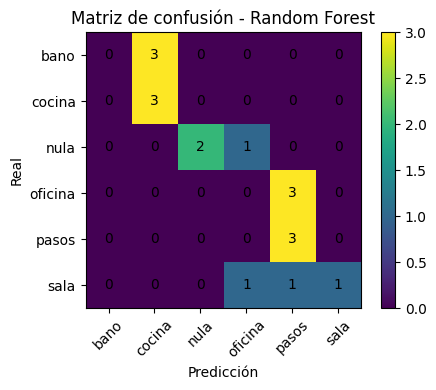


KNN
Accuracy REAL: 0.4444
F1-score macro: 0.3576

Classification report:

              precision    recall  f1-score   support

        bano       0.00      0.00      0.00         3
      cocina       0.43      1.00      0.60         3
        nula       1.00      0.33      0.50         3
     oficina       0.00      0.00      0.00         3
       pasos       0.38      1.00      0.55         3
        sala       1.00      0.33      0.50         3

    accuracy                           0.44        18
   macro avg       0.47      0.44      0.36        18
weighted avg       0.47      0.44      0.36        18



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


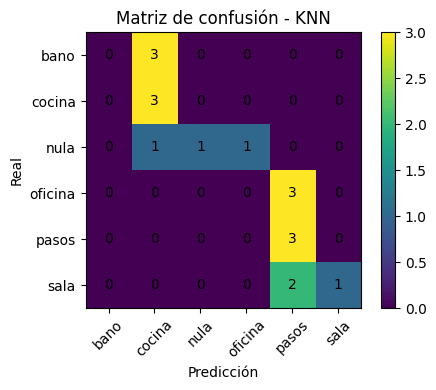


SVM
Accuracy REAL: 0.3889
F1-score macro: 0.2687

Classification report:

              precision    recall  f1-score   support

        bano       0.00      0.00      0.00         3
      cocina       0.50      1.00      0.67         3
        nula       0.50      0.33      0.40         3
     oficina       0.00      0.00      0.00         3
       pasos       0.38      1.00      0.55         3
        sala       0.00      0.00      0.00         3

    accuracy                           0.39        18
   macro avg       0.23      0.39      0.27        18
weighted avg       0.23      0.39      0.27        18



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


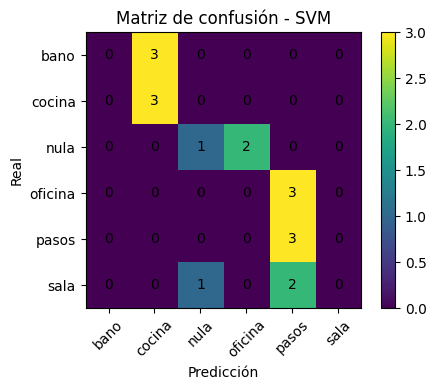

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np


modelos = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel="rbf")
}

clases = sorted(y_test.unique())


for nombre, modelo in modelos.items():

    modelo.fit(X_train, y_train)
    pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average="macro")

    print("\n======================")
    print(nombre)
    print("Accuracy REAL:", round(acc, 4))
    print("F1-score macro:", round(f1, 4))
    print("\nClassification report:\n")
    print(classification_report(y_test, pred))

    cm = confusion_matrix(y_test, pred)

    plt.figure(figsize=(5,4))
    plt.imshow(cm)
    plt.title(f"Matriz de confusión - {nombre}")
    plt.colorbar()

    plt.xticks(np.arange(len(clases)), clases, rotation=45)
    plt.yticks(np.arange(len(clases)), clases)

    for i in range(len(clases)):
        for j in range(len(clases)):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


## Analisis de resultados
En general, los tres modelos presentaron un desempeño limitado, con dificultades para distinguir correctamente varias clases del conjunto de prueba.

El Random Forest obtuvo el mejor rendimiento global, alcanzando la mayor exactitud y F1-score, aunque su desempeño sigue siendo moderado. El KNN mostró resultados ligeramente inferiores y un comportamiento similar en los errores de clasificación. Por su parte, el SVM fue el modelo con menor desempeño, presentando más fallos al diferenciar las categorías.

Las matrices de confusión nos permiten observar que algunas clases fueron reconocidas con mayor facilidad, mientras que otras casi no fueron identificadas.

## Observaciones
Es importante señalar que el bajo desempeño observado en los modelos no necesariamente se debe a un mal entrenamiento, sino a la calidad del conjunto de prueba. Durante la evaluación, se identificó que varios audios del test no contienen sonidos acordes a sus etiquetas y, en muchos casos, presentan principalmente ruido.

Esta inconsistencia entre las etiquetas y el contenido real de los audios dificulta que los modelos puedan clasificar correctamente las muestras, aun cuando hayan aprendido patrones adecuados durante el entrenamiento. Como consecuencia, métricas como el accuracy y el F1-score macro se vieron afectadas negativamente.